<h1 style="text-align: center;">A Tutorial for (Probabilistic) Bayesian Neural Networks</h1>
<p style="text-align: center;"> A short version of <a href="https://keras.io/examples/keras_recipes/bayesian_neural_networks/">Khalid Salama's blog post</a> with Son Hai Le's modifications </p>

**Goal of this document**
- Implementation of standard neural network ([SNN](http://www.deeplearningbook.org))
- Implementation of 2 types of Bayesian neural network ([BNN](https://ieeexplore.ieee.org/document/9756596)):
    * BNN: deal with [epistemic uncertainty](https://www.sciencedirect.com/science/article/abs/pii/S0167473008000556)
    * Probabilistic BNN: deal with both [aleatoric uncertainty](https://www.sciencedirect.com/science/article/abs/pii/S0167473008000556) and [epistemic uncertainty](https://www.sciencedirect.com/science/article/abs/pii/S0167473008000556)


**What are different compared to the original** [Khalid Salama's blog post](https://keras.io/examples/keras_recipes/bayesian_neural_networks)?
- Make the document more succinct, remove unnecessary theory parts
- Add an [exploratory data analysis (EDA)](https://en.wikipedia.org/wiki/Exploratory_data_analysis)
- Add codes to save and load the weights of the model
- Add visualization of the predictions

*Note: follow [hyperlinks]() to see more details*

## Python packages
 - [TensorFlow](https://www.tensorflow.org/) 2.3 or higher: for neural networks
 - [TensorFlow Probability](https://www.tensorflow.org/probability) (`pip install tensorflow-probability`): for Bayesian neural networks
 - [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/wine_quality) (`pip install tensorflow-datasets`): for dataset
 - [Pandas](https://pandas.pydata.org/) (`pip install pandas`): for data structures and data analysis
 - [SeaBorn](https://seaborn.pydata.org/) (`pip install seaborn`) and [matplotlib](https://matplotlib.org/) (`pip install matplotlib`): for data visualization

 TensorFlow 2.3 이상: 머신러닝 및 딥러닝을 위한 오픈소스 라이브러리로, 신경망 구축에 주로 사용됩니다.

TensorFlow Probability (pip install tensorflow-probability): 베이지안 신경망 구현을 위한 확률적 계산 및 통계 모델링을 지원하는 TensorFlow 확장 라이브러리입니다.

TensorFlow Datasets (pip install tensorflow-datasets): 다양한 머신러닝 데이터셋을 손쉽게 다운로드하고 사용할 수 있게 해주는 TensorFlow의 데이터셋 라이브러리입니다.

Pandas (pip install pandas): 데이터 조작 및 분석을 위한 라이브러리로, 효율적인 데이터 구조를 제공하며 테이블 형태의 데이터를 다루는 데 유용합니다.

SeaBorn (pip install seaborn): 데이터 시각화를 위한 파이썬 라이브러리로, 복잡한 통계 그래프를 쉽게 생성할 수 있습니다. Matplotlib 기반으로 작동합니다.

Matplotlib (pip install matplotlib): 다양한 형태의 그래프와 차트를 생성하기 위한 파이썬 데이터 시각화 라이브러리로, 2D 및 3D 그래프를 그릴 수 있습니다.
gitignore추가


In [85]:
# %matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import HTML

# 아래는 그래프등을 보여주기위한 주피터노트북 관련된 형식 설정(무시가능)
HTML("""
<style>
h1,h2,h3 {
	margin: 1em 0 0.5em 0;
	font-weight: 600;
	font-family: 'Titillium Web', sans-serif;
	position: relative;  
	font-size: 36px;
	line-height: 40px;
	padding: 15px 15px 15px 2.5%;
	color: #1E8449;
	box-shadow: 
		inset 0 0 0 1px rgba(246,38,100, 1), 
		inset 0 0 5px rgba(246,3,100, 1),
		inset -285px 0 35px #D5F5E3;
	border-radius: 0 10px 0 15px;
	background: #fff
    
}
</style>
""")

## Dataset
#### Feautures description
The wine subset of [Wine Quality](https://archive.ics.uci.edu/ml/datasets/wine+quality) dataset:
- 4,898 examples
- Input: 11 numerical physicochemical features of the wine
    * Fixed acidity: the amount of tartaric acid in wine and (g/dm3)
    * Volatile acidity: the amount of acetic acid in the wine (g/dm3)
    * Citric acid: the amount of citric acid in the wine (g/dm3)
    * Residual sugar: the amount of sugar remaining after fermentation (g/dm3)
    * Chlorides: the amount of salt in the wine (g/dm3)
    * Free sulfur dioxide: the amount of free sulfur dioxide in the wine (mg/dm3)
    * Total sulfur dioxide: the amount of free and bound forms of sulfur dioxide (mg/dm3)
    * Density: the density of the wine (g/cm3)
    * pH: the pH of the wine
    * Sulfates: the amount of sulfur dioxide bound to potassium and sodium (g/dm3)
    * Alcohol: the alcohol content of the wine (% by volume)
- Output: the quality of the wine, which is ranged from 1 to 10 (the higher, the better)

=> **A regression task**: predict the wine quality score from the input features.


#### 11가지의 사전 조건(산미, 당도 등등.. )을 가지고 quality 점수를 도출하는 모델 작성

In [86]:
# Load the wine quality dataset
data_tf = tfds.load('wine_quality',split='train')
df = tfds.as_dataframe(data_tf)

# Rename columns
df.columns = ["fixed acidity","volatile acidity","citric acid","residual sugar","chlorides",
              "free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol","quality"]

# Create a box plot for all numerical columns
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,9.0,0.054,0.34,1.00080,7.6,44.0,3.22,18.35,0.55,197.0,0.32,5
1,12.2,0.063,0.49,0.99110,6.3,35.0,3.38,1.20,0.42,92.0,0.27,6
2,11.2,0.029,0.11,0.99076,5.3,6.0,3.51,1.10,0.48,51.0,0.43,4
3,9.0,0.110,0.27,0.99672,6.6,20.0,3.08,10.70,0.41,103.0,0.41,6
4,12.0,0.035,0.30,0.99016,5.9,57.0,3.09,3.80,0.34,135.0,0.34,6


#### Descriptive statistics
#### 설명 통계(Descriptive statistics)는 데이터를 요약하고 설명하는 통계 기법입니다. 이를 통해 데이터의 중심 경향, 퍼짐 정도, 분포 형태 등의 특징을 쉽게 파악할 수 있습니다.

In [87]:
# Statistical Analysis 
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,10.514268,0.045772,0.334192,0.994027,6.854788,35.308086,3.188267,6.391415,0.489847,138.360657,0.278241,5.877909
std,1.230621,0.021848,0.121020,0.002991,0.843868,17.007137,0.151001,5.072058,0.114126,42.498066,0.100795,0.885639
min,8.000000,0.009000,0.000000,0.987110,3.800000,2.000000,2.720000,0.600000,0.220000,9.000000,0.080000,3.000000
25%,9.500000,0.036000,0.270000,0.991723,6.300000,23.000000,3.090000,1.700000,0.410000,108.000000,0.210000,5.000000
50%,10.400000,0.043000,0.320000,0.993740,6.800000,34.000000,3.180000,5.200000,0.470000,134.000000,0.260000,6.000000
75%,11.400000,0.050000,0.390000,0.996100,7.300000,46.000000,3.280000,9.900000,0.550000,167.000000,0.320000,6.000000
max,14.200000,0.346000,1.660000,1.038980,14.200000,289.000000,3.820000,65.800003,1.080000,440.000000,1.100000,9.000000


In [88]:
# datatype information:
df.info()

# 데이터 베이스 정보 불러오기(신경 안써도됨)

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float32
 1   volatile acidity      4898 non-null   float32
 2   citric acid           4898 non-null   float32
 3   residual sugar        4898 non-null   float32
 4   chlorides             4898 non-null   float32
 5   free sulfur dioxide   4898 non-null   float32
 6   total sulfur dioxide  4898 non-null   float32
 7   density               4898 non-null   float32
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float32
 10  alcohol               4898 non-null   float32
 11  quality               4898 non-null   int32  
dtypes: float32(10), float64(1), int32(1)
memory usage: 248.9 KB


 #### Data preprocessing
  #### 데이터 전처리 과정 데이터프레임(df) 내의 결측값을 시각화하기 위한 코드
  #####  Seaborn 라이브러리의 heatmap 함수(매트랩 그래프 그리는거 비슷한 느낌)

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

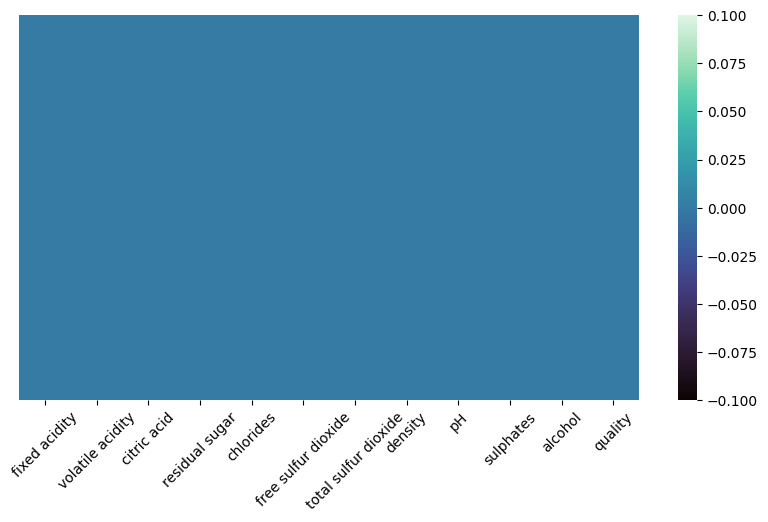

In [89]:
#check for missing values:

# matplotlib 라이브러리를 사용하여 그림의 크기를 설정합니다. 여기서는 가로 10, 세로 5의 크기로 설정되어 있습니다.
plt.figure(figsize=(10,5))

# Seaborn 라이브러리의 heatmap 함수를 사용하여 결측값을 표시하는 히트맵을 생성합니다. df.isnull()을 통해 데이터프레임 내의 결측값을 찾고, yticklabels=False로 설정하여 y축 레이블을 숨깁니다. cbar=True는 오른쪽에 컬러바를 표시하도록 설정하며, cmap='mako'를 사용하여 색상 팔레트를 지정합니다.
sns.heatmap(df.isnull(),yticklabels=False,cbar=True,cmap='mako')

# x축 레이블의 회전 각도를 설정합니다. 여기서는 45도로 회전하도록 설정되어 있습니다.
plt.xticks(rotation=45)

# 데이터프레임 내의 결측값 개수를 각 열별로 합산하여 출력합니다.
df.isnull().sum()

#### Exploratory data analysis (EDA)
##### 탐색적 데이터 분석(Exploratory Data Analysis, EDA)은 데이터를 다양한 관점에서 살펴보고, 데이터의 구조, 패턴, 이상치, 변수간의 관계 등을 파악하는 과정입니다. EDA를 통해 데이터에 대한 이해를 높이고, 적절한 모델링 방법을 결정하거나 데이터 전처리를 수행할 수 있다.

**Count plot of quality variable**

<Axes: xlabel='quality', ylabel='count'>

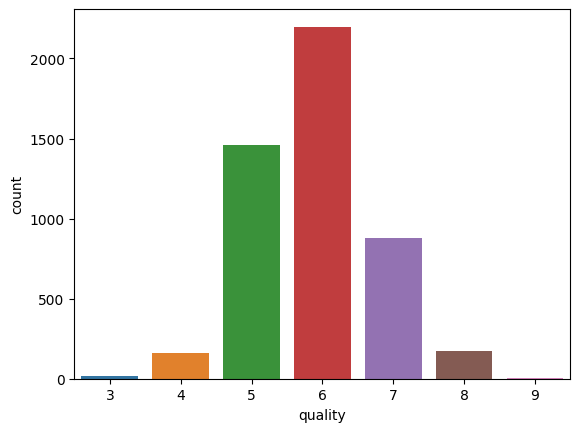

In [90]:
# Seaborn 라이브러리의 막대형 합산 그래프
sns.countplot(x='quality',data=df)  

**Lets see whether our data has outliers or not:**
- By the below plot: lots of outliers
- However, won't remove them because they are not errors, they are just extreme values

**데이터에 특이치가 있는지 여부를 확인합니다:**
- 많은 평균값을 벗어나는 값들
- 하지만 오류가 아니라 극단적인 유효한 값이기 때문에 무시하지 않는다.

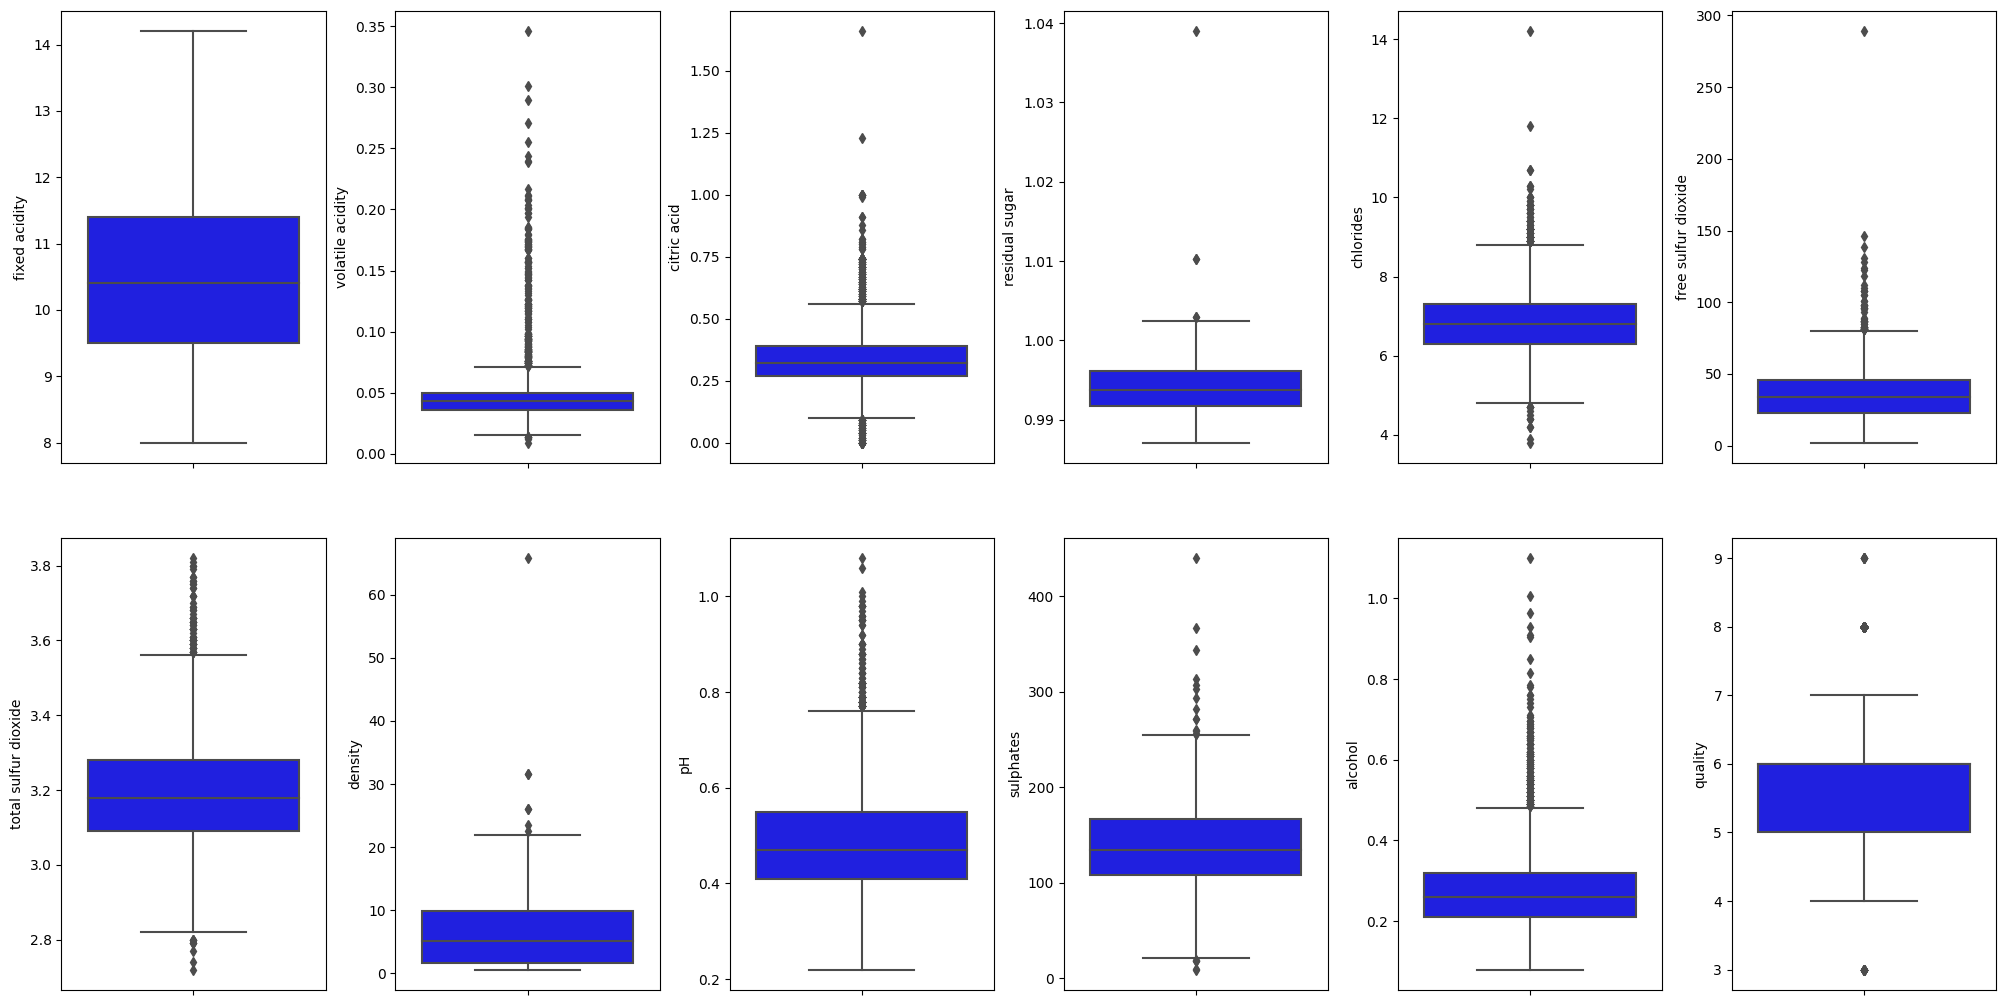

In [91]:
# 박스 플롯 생성을 위한 서브플롯 그리드 설정
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(20,10))

# 박스 플롯을 그릴 서브플롯 인덱스 초기화
index = 0

# 서브플롯 배열을 1차원 배열로 변환
ax = ax.flatten()

# 데이터프레임의 각 열에 대해 반복하여 박스 플롯 생성
for col, value in df.items():
    # 해당 열의 박스 플롯 생성 및 서브플롯에 그리기
    sns.boxplot(y=col, data=df, color='b', ax=ax[index])
    
    # 서브플롯 인덱스 증가
    index += 1

# 전체 그림 레이아웃 조정
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)


**Find correlated columns from below figure**
- Wine quality:
    * Positively correlated with the fixed acidity (strongly)
    * Negatively correlated with the residual sugar (strongly)
- Residual sugar:
    * Positively correlated with the density and sulfates (strongly)
- Chlorides: 
    * Negatively correlated with the total sulfur dioxide (strongly)
- Free sulfur dioxide:
    * Positively correlated with the sulphates (strongly)
- Density:
    * Positively correlated with the sulphates (strongly)

**아래 그림에서 상관된 열 찾기**
- 와인 품질:
    * 고정된 산도와 양의 상관관계(강력)
    * 잔류 당과 음의 상관관계(강력)
- 잔류 설탕:
    * 밀도 및 황산염과 양의 상관 관계(강력)
- 염화물: 
    * 총 이산화황과 음의 상관관계(강력)
- 유리 이산화황:
    * 황산염과 양의 상관 관계(강력)
- 밀도:
    * 황산염과 양의 상관 관계(강력)

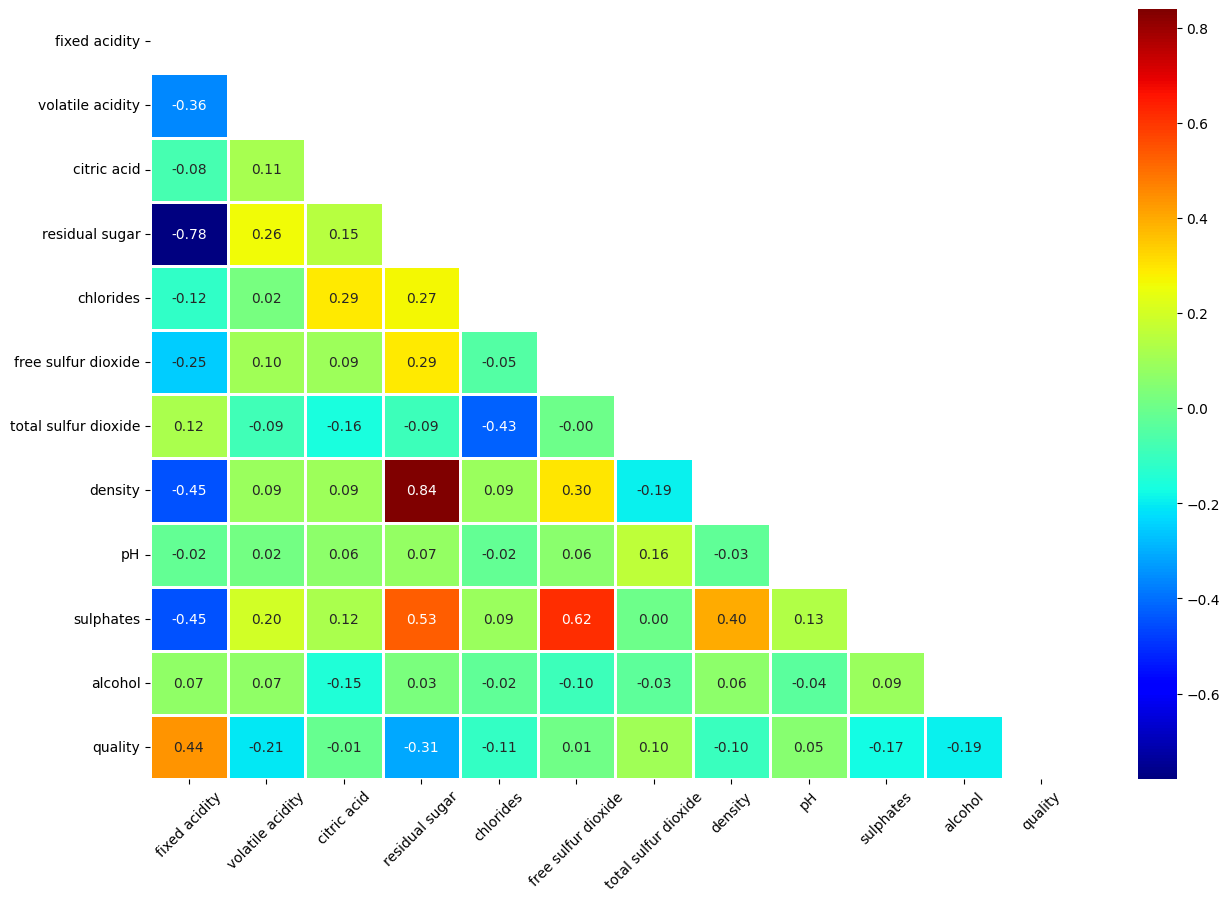

In [92]:

# 히트맵 그림 크기 설정
plt.figure(figsize=(15,10))

# 상삼각행렬 마스크 생성
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

# 데이터프레임 상관계수 히트맵 생성
sns.heatmap(df.corr(), annot=True, fmt='.2f', linewidths=2, cmap='jet', mask=mask)

# x축 레이블 회전 각도 설정
plt.xticks(rotation=45)

# 그림 출력
plt.show()


**Histogram plot of all features from the below figures**
- Few of them:  normally distributed
- Other: rightly skewed
- The range of each feature: not huge.

**아래 그림의 모든 형상에 대한 히스토그램 그림**
- 그 중 일부: 정규 분포
- 기타: 오른쪽으로 치우침
- 각 기능의 범위: 크지 않습니다.

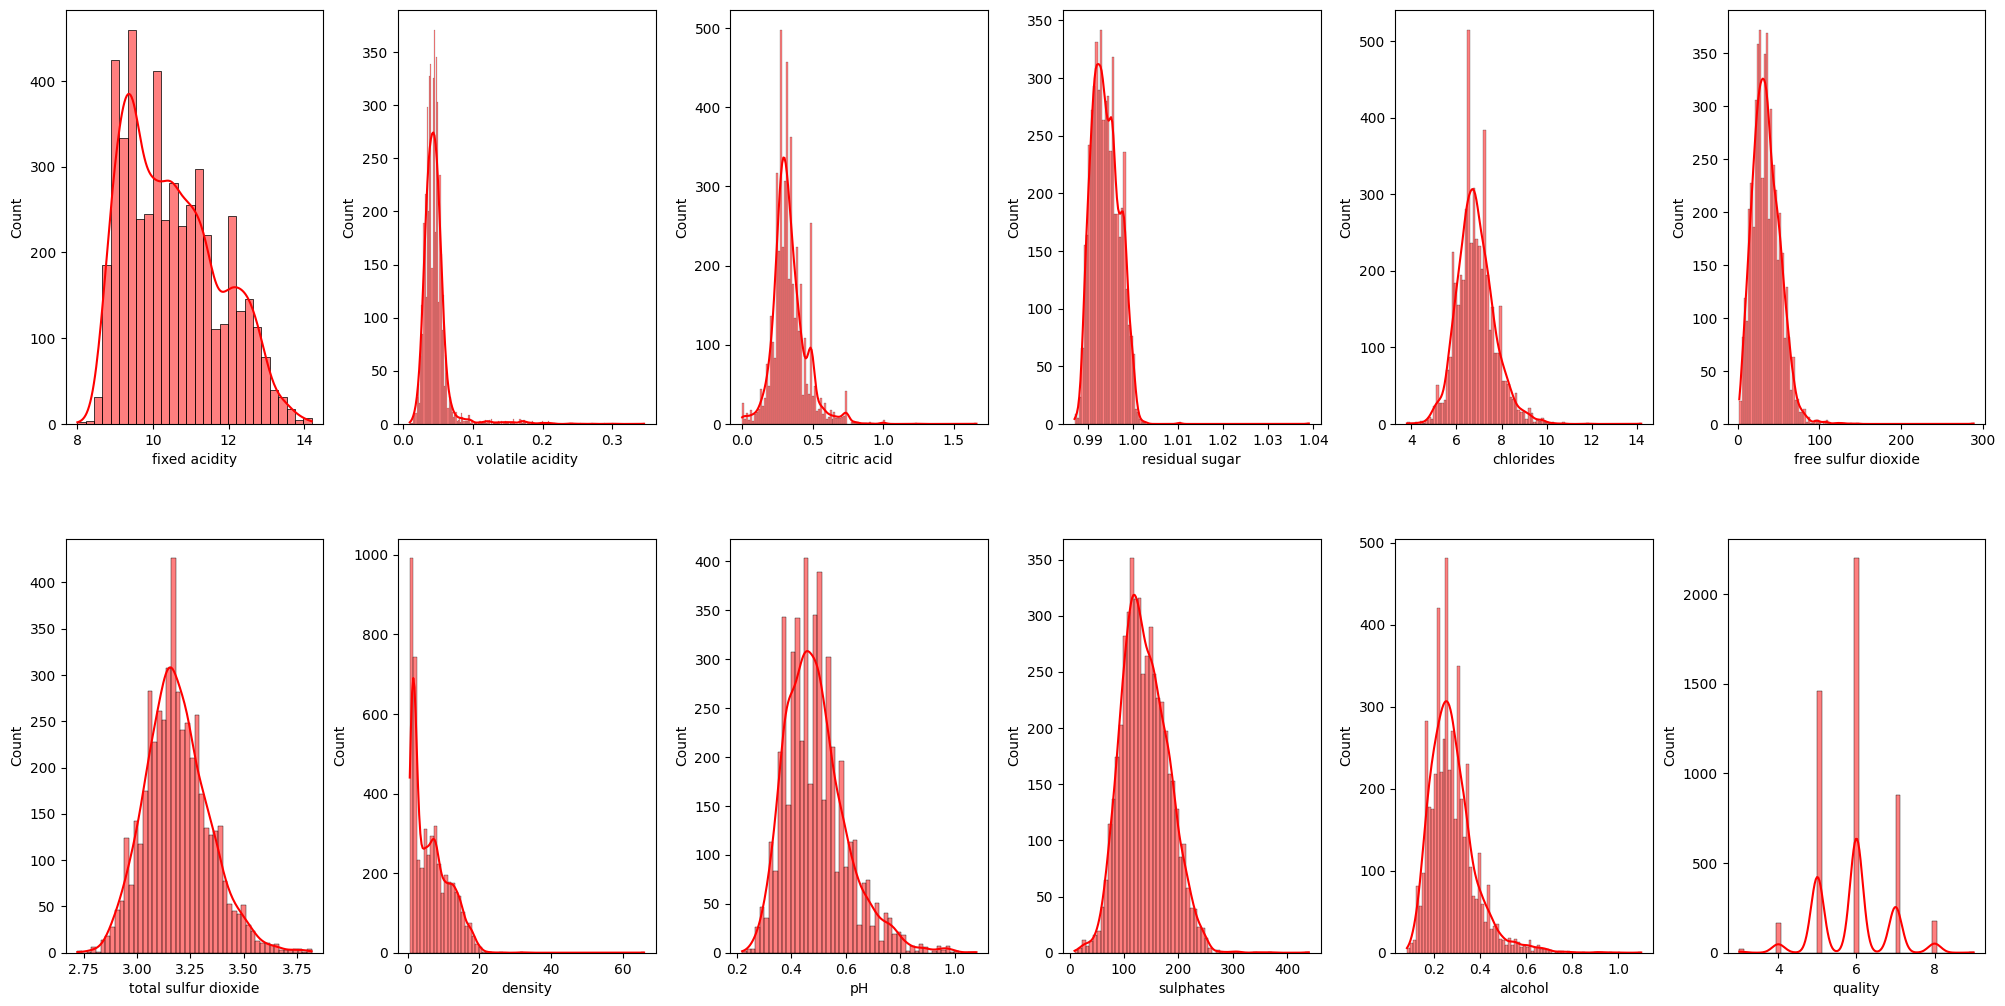

In [93]:
# 데이터프레임(df)의 모든 변수에 대해 히스토그램을 생성하는 파이썬 코드다. 


# 히스토그램 생성을 위한 서브플롯 그리드 설정
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(20,10))

# 히스토그램을 그릴 서브플롯 인덱스 초기화
index = 0

# 서브플롯 배열을 1차원 배열로 변환
ax = ax.flatten()

# 데이터프레임의 각 열에 대해 반복하여 히스토그램 생성
for col, value in df.items():
    # 해당 열의 히스토그램 생성 및 서브플롯에 그리기
    sns.histplot(value, color='r', ax=ax[index], kde=True)
    
    # 서브플롯 인덱스 증가
    index += 1

# 전체 그림 레이아웃 조정
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)


**Conclusions after performing EDA**
- Used the Wine Quality dataset provided by UCI to perform EDA
- Discussed how we can perform EDA techniques such as data loading, data wrangling, correlation between variables
- Found that the dataset has outliers and rightly skewed features
- Future works: 
    * Remove outliers
    * Apply feature scaling to the dataset
    * Handle the class imbalance problem
- ***Now, let focus on making a Bayesian neural network model to predict the wine quality score***

**EDA 수행 후의 결론**
탐색적 데이터 분석(Exploratory Data Analysis, EDA)
- UCI에서 제공하는 와인 품질 데이터 세트를 사용하여 EDA를 수행
- 데이터 로드, 데이터 논쟁, 변수 간의 상관 관계와 같은 EDA 기술을 수행하는 방법에 대해 논의했습니다
- 데이터 집합에 특이치와 오른쪽으로 치우친 형상이 있음을 발견함
- 향후 작업: 
    * 특이치 제거
    * 데이터 세트에 피쳐 스케일링 적용
    * 클래스 불균형 문제 처리
- ***이제 와인 품질 점수를 예측하기 위한 베이지안 신경망 모델을 만드는 데 집중하겠습니다**

## Create training and evaluation datasets
- Construct `get_train_and_test_splits()` function to:
    * Load the `wine_quality` dataset using `tfds.load()`
    * Convert the target feature to float
    * Shuffle the dataset and split it into training and test sets
    * Take the first `train_size` examples as the train split, and the rest as the test split

    ## 교육 및 평가 데이터셋 생성
- 'get_train_and_test_splits()' 함수를 다음과 같이 구성합니다:
    * 'tfds(tensorflow_datasets).load()'를 사용하여 'wine_quality' 데이터 세트를 로드합니다
    * 대상 피쳐를 부동으로 변환
    * 데이터 세트를 순서대로 섞고 교육 및 테스트 세트로 분할
    * 첫 번째 'train_size' 에는 훈련 세트 분할로, 나머지는 테스트 세트를 위한 분할을 실행한다.

In [94]:
#  TensorFlow 데이터셋(tfds)의 "wine_quality" 데이터셋을 로드하고, 훈련 데이터셋과 테스트 데이터셋으로 분할하는 함수를 정의한 파이썬 코드

dataset_size = 4898
# 훈련 및 테스트 데이터셋 분할 함수 정의
def get_train_and_test_splits(train_size, batch_size=1):
    # 데이터셋이 작고 메모리에 적재 가능하기 때문에 동일한 크기의 버퍼로 미리 가져오기(prefetch) 수행
    dataset = (
        tfds.load(name="wine_quality", as_supervised=True, split="train")
        .map(lambda x, y: (x, tf.cast(y, tf.float32)))
        .prefetch(buffer_size=dataset_size)
        .cache()
    )
    # 데이터셋의 크기만큼 버퍼로 섞기(shuffle) 수행
    train_dataset = (
        dataset.take(train_size).shuffle(buffer_size=train_size).batch(batch_size)
    )
    # 훈련 데이터 이후 데이터를 테스트 데이터셋으로 사용
    test_dataset = dataset.skip(train_size).batch(batch_size)

    return train_dataset, test_dataset



##### 해당 코드에서 알아두면 좋은 메서드(기능)

##### .shuffle(buffer_size=train_size): 이 메서드는 데이터셋을 무작위로 섞습니다.
buffer_size 매개변수는 섞기 전에 로드할 데이터의 버퍼 크기를 결정합니다. 버퍼 크기가 작을수록 섞이는 정도가 낮아지고, 더 크면 섞이는 정도가 높아집니다. 여기서는 train_size와 같게 설정하여 모든 데이터를 완전히 섞어줍니다. 하지만 메모리 문제가 없다면 일반적으로 buffer_size를 전체 데이터셋 크기와 같게 설정하는 것이 좋습니다.

##### .batch(batch_size): 이 메서드는 데이터셋을 일정 크기의 배치로 나눕니다.
batch_size 매개변수는 한 배치에 포함될 데이터 샘플의 수를 결정합니다. 이렇게 배치로 구성된 데이터셋은 모델 학습 시 가중치를 업데이트하는 데 사용됩니다. 작은 배치 크기는 더 빈번한 가중치 업데이트를 통해 더 빠르게 수렴할 수 있지만, 큰 배치 크기는 더 정확한 그래디언트 추정을 제공하고 메모리 효율성이 높습니다.

## Compile, train, and evaluate the model
- NN architecture: 2 layers with 8 units each (can be tuned)
- Learning rate: 0.001 (can be tuned)
- Construct `run_experiment()` function to:
    * Compile the model: `model.comnpile()`
    * Train the model: `model.fit()`
    * Evaluate the model on the train and test sets: `model.evaluate()`

    ## 모델 컴파일, 교육 및 평가
- NN 아키텍처: 각각 8개의 유닛이 있는 2개의 레이어(튜닝 가능)
- 학습률: 0.001(조정 가능)
- run_experiment()' 함수를 구성하여 다음을 수행합니다:
    * 모델 'model.comnpile()'을 컴파일합니다
    * 모델 교육: 'model.fit()'
    * 열차 및 테스트 세트의 모델 평가: 'model.evaluate()'


####  주어진 모델과 손실 함수를 사용하여 실험을 실행하는 함수를 정의한 파이썬 코드,  모델을 컴파일하고, 훈련 데이터셋을 사용하여 모델을 학습시키며, 훈련 및 테스트 데이터셋에 대한 모델 성능을 평가하는 실질적으로 논문 작성시 이행해야되는 코드이다.

In [95]:
# 은닉층 설정 (2개의 은닉층, 각각 8개의 유닛)
hidden_units = [8, 8]

# 학습률 설정
learning_rate = 0.001
num_epochs = 2000
# 실험 실행 함수 정의
def run_experiment(model, loss, train_dataset, test_dataset):
    # 모델 컴파일 (최적화기, 손실 함수, 평가 지표 설정)
    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError()],
    )

# 메시지 출력은 무시해도 좋음 버그나 오류가 났을때 어디에서 났는지 확인하기 위함

    # 모델 훈련 시작 메시지 출력
    print("Start training the model...")

    # 모델 훈련 수행 (훈련 데이터셋, 검증 데이터셋 사용)
    model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

    # 모델 훈련 완료 메시지 출력
    print("Model training finished.")

    # 훈련 데이터셋을 사용한 모델 평가 (RMSE 계산)
    _, rmse = model.evaluate(train_dataset, verbose=0)
    print(f"Train RMSE: {round(rmse, 3)}")

    # 모델 성능 평가 시작 메시지 출력
    print("Evaluating model performance...")

    # 테스트 데이터셋을 사용한 모델 평가 (RMSE 계산)
    _, rmse = model.evaluate(test_dataset, verbose=0)
    print(f"Test RMSE: {round(rmse, 3)}")


## Create model inputs (i.e., name the inputs)
## 모델에 들어갈 입력값들 설정하기


#### 주어진 특성 이름 목록에 대해 모델의 입력 레이어를 생성하는 함수를 정의한 파이썬 코드, 각 특성에 대해 입력 레이어를 생성하고, 이를 딕셔너리에 저장하여 반환한다.

딕셔너리 란: 사전형 저장형식인데 사전이 낱말에 설명이 써있듯 유일한 key 값에 value 를 저장해놓는것을 뜻함. 프로그래밍에서 사전형 저장방식이 나중에 읽어올때 속도가 빠르기에 사용됨

In [96]:
# 특성 이름 목록 설정
FEATURE_NAMES = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
]

# 모델 입력 생성 함수 정의
def create_model_inputs():
    # 입력 딕셔너리 초기화
    inputs = {}

    # 각 특성에 대해 입력 레이어 생성 및 딕셔너리에 저장
    for feature_name in FEATURE_NAMES:
        inputs[feature_name] = layers.Input(
            name=feature_name, shape=(1,), dtype=tf.float32
        )
    
    # 생성된 입력 딕셔너리 반환
    return inputs


## Experiment 1: standard neural network
- Construct `create_baseline_model()` function to create a standard deterministic neural network

## 실험 1: 표준 신경망(SNN 기법)
- 'create_baseline_model()' 함수를 구성하여 표준 결정론적 신경망(SDNN)을 만든다.

기본 모델을 생성하는 함수를 정의한 파이썬 코드
1. 먼저 입력 레이어를 생성
2. 특성 벡터를 만들고
3. 배치 정규화를 적용
4. 결정적 가중치를 사용하여 은닉층을 생성
5. 마지막으로 출력층을 생성하여 모델을 완성

#### 1. 먼저 입력 레이어를 생성
#### 2. 특성 벡터를 만들고
이 단계에서는 각 특성(예: 고정 산도, 휘발성 산도 등)에 대한 입력 레이어를 하나의 특성 벡터로 결합한다.


특성 벡터는 여러 개의 특성을 포함하는 데이터의 표현입니다. 이 예시에서는 와인 품질 데이터셋에서 각 와인 샘플은 11개의 특성으로 구성되어 있다. = 각 샘플에 대한 특성 벡터는 11차원 벡터이다. 


이 단계에서는 입력 레이어를 연결하여 신경망이 각 샘플에 대해 11차원 특성 벡터를 처리할 수 있도록 한다.
#### 3. 배치 정규화를 적용
신경망의 각 층에서 입력 분포를 정규화하는 과정


이를 통해 가중치 업데이트가 더 효율적으로 이루어지며, 학습 속도가 향상되고 신경망이 초기 가중치 값에 덜 민감하게 되어, 학습 과정이 더 안정적으로 진행된다.


배치 정규화는 각 층의 입력 데이터를 평균이 0이고 표준편차가 1인 분포로 변환한다. (정규화 관련 개념)


#### 4. 결정적 가중치를 사용하여 은닉층을 생성
*** 은닉층은 신경망의 핵심 구성 요소로, 입력 데이터에서 패턴을 학습하는 역할이다. 실질적으로 논문 작성시 중요한 부분 *** 


이 예제에서는 두 개의 완전 연결된(Dense) 은닉층을 사용하며, 각 은닉층에는 8개의 뉴런이 있다.


위에 있었음
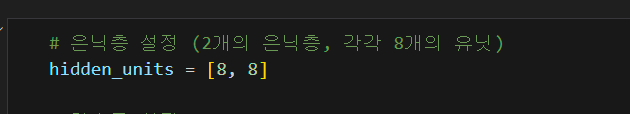


hidden_units 리스트의 각 요소에 대해 Dense 층이 생성되고, 각 층에는 해당 요소의 값(여기서는 8)만큼의 뉴런이 포함된다.


각 뉴런은 주어진 특성 벡터에 대해 가중치를 학습하고, 시그모이드 활성화 함수(아래 개념 첨부하였음)를 사용하여 0과 1 사이의 값을 출력하며, 이를 통해 뉴런의 출력 값이 일정 범위 내에서 유지되게 한다.(안정적인 결과값 도출)
#### 5. 마지막으로 출력층을 생성하여 모델을 완성

출력층은 신경망이 학습한 패턴을 바탕으로 예측 값을 생성하는 역할을 한다.


 이 예제에서는 회귀 문제를 해결하기 때문에, 출력층은 단일 뉴런을 가지며, 별도의 활성화 함수를 사용하지 않는다.
 
 
 이 뉴런은 신경망의 최종 출력 값을 생성한다.
 
 
 *** 출력층의 목적은 신경망이 학습한 패턴을 사용하여 입력 데이터에 대한 연속적인 예측 값을 출력하는 것 = 우리가 논문에서 얻어야하는 결과값 ***

시그모이드 활성화 함수는 신경망에서 많이 사용되는 비선형 활성화 함수 중 하나


시그모이드 함수는 S자 형태를 가지며, 입력 값을 0과 1 사이의 출력 값으로 변환합니다. 

시그모이드 함수는 다음과 같은 수식으로 정의됩니다.


σ(x) = 1 / (1 + exp(-x))


여기서 x는 입력 값이고, exp(-x)는 e의 -x 거듭제곱입니다.



시그모이드 활성화 함수는 다음과 같은 특징이 있습니다:



출력 값의 범위가 0과 1 사이입니다. 이는 신경망의 출력 값이 특정 범위 내에서 유지되도록 도와줍니다.
함수의 미분이 간단하며, 미분 값은 최대 0.25입니다. 이는 경사 하강법(Gradient Descent)과 같은 최적화 알고리즘에서 가중치 업데이트를 수월하게 합니다.
시그모이드 함수는 입력 값이 0에 가까울 때 가장 높은 민감도를 가지며, 입력 값이 매우 크거나 작을 때는 민감도가 낮아집니다. 이로 인해 신경망이 큰 가중치 값을 학습하는 것을 방지하며, 일반화 능력을 향상시킵니다.


그러나 시그모이드 함수는 몇 가지 단점도 있습니다:

입력 값의 절댓값이 클 경우, 시그모이드 함수의 미분 값이 매우 작아져서 기울기 소실(Vanishing Gradient) 문제가 발생할 수 있습니다. 이 문제는 신경망이 깊어질수록 학습이 어려워지는 원인이 됩니다.
시그모이드 함수는 출력 값의 평균이 0이 아닌 0.5로, 학습 과정에서 가중치 업데이트가 불균형할 수 있습니다.
이러한 단점으로 인해, 현재는 ReLU(Rectified Linear Unit)와 같은 다른 활성화 함수들이 더 널리 사용되고 있습니다. 그러나 시그모이드 함수는 이진 분류 문제의 출력층에서 여전히 널리 사용되며, 확률 값을 출력하는 데 적합합니다.

In [97]:
# 기본 모델 생성 함수 정의
def create_baseline_model():
    # 입력 레이어 생성
    inputs = create_model_inputs()
    input_values = [value for _, value in sorted(inputs.items())]
    
    # 입력 레이어를 연결하여 특성 벡터 생성
    features = keras.layers.concatenate(input_values)
    
    # 배치 정규화 적용
    features = layers.BatchNormalization()(features)

    # 은닉층 생성 (결정적 가중치 사용)
    for units in hidden_units:
        features = layers.Dense(units, activation="sigmoid")(features)
    
    # 출력층 생성 (결정적 출력: 단일 점 추정)
    outputs = layers.Dense(units=1)(features)

    # 입력과 출력을 사용하여 모델 생성
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model


- Split the wine dataset into training and test sets, with 85% and 15% of the examples, respectively

주어진 데이터 셋을 훈련 케이스(트케) 테스트케이스(테케)로 나눈다.

In [98]:
dataset_size = 4898
batch_size = 256
train_size = int(dataset_size * 0.85)
train_dataset, test_dataset = get_train_and_test_splits(train_size, batch_size)

- Let's train the baseline model: 
    * `.save_weights()`: save the weights of the model
    * `.load_weights()`: load the weights of the model
- Use the `MeanSquaredError` as the loss function

- 기본 모델을 교육해 보겠습니다: 
    * ".save_between": 모델의 가중치를 저장
    * ''.load_between'': 모델의 가중치 로드
- '평균 제곱 오차'를 손실 함수로 사용합니다(이건 나중에 달라질수 있음 근데 본질적으로는 본래값하고 결과값이 얼마나 차이나나에 대한 것)

In [99]:
num_epochs = 100  # 모델을 학습할 때 사용할 에폭(epoch) 수를 100으로 설정합니다.

mse_loss = keras.losses.MeanSquaredError()  # 평균 제곱 오차(Mean Squared Error) 손실 함수를 사용합니다.

baseline_model = create_baseline_model()  # 기본 모델을 생성합니다.

# 모델 가중치가 저장된 파일이 있는지 확인합니다.
if os.path.exists('pretrained_model/baseline_model.h5'):
    print("Model exists, load weights")  # 가중치 파일이 있으면, 파일에서 가중치를 불러옵니다.
    baseline_model.load_weights('pretrained_model/baseline_model.h5')
else:
    print("Model not exists, train model")  # 가중치 파일이 없으면, 모델을 학습시킵니다.
    run_experiment(baseline_model, mse_loss, train_dataset, test_dataset)
    baseline_model.save_weights('pretrained_model/baseline_model.h5')  # 학습된 모델의 가중치를 저장합니다.


Model exists, load weights


- Let's take a sample from the test set use the model to obtain predictions for them
- Baseline model: deterministic
    * A single a *point estimate* prediction for each test example
    * No information about the uncertainty of the model nor the prediction


    - 모형을 사용하여 검정 세트에서 표본을 추출하여 예측값을 구하겠습니다
- 기준 모형: 결정론적 모형
    * 각 검정 예제에 대한 단일 *점 추정치* 예측
    https://en.wikipedia.org/wiki/Point_estimation
    * 모형의 불확실성 또는 예측에 대한 정보가 없음

In [100]:
sample = 50  # 테스트 데이터셋에서 50개의 샘플을 사용합니다.

# 테스트 데이터셋을 섞고(shuffle), 50개의 샘플을 뽑습니다.
examples, targets = list(test_dataset.unbatch().shuffle(batch_size * 10).batch(sample))[0]

predicted = baseline_model(examples).numpy()  # 기본 모델을 사용하여 예측값을 계산합니다.

# 샘플 중 처음 10개에 대한 예측값과 실제값을 출력합니다.
for idx in range(sample):
    if idx == 10:
        break
    print(f"Predicted: {round(float(predicted[idx][0]), 1)} - Actual: {targets[idx]}")


Predicted: 5.5 - Actual: 6.0
Predicted: 6.2 - Actual: 7.0
Predicted: 6.2 - Actual: 6.0
Predicted: 5.6 - Actual: 6.0
Predicted: 5.5 - Actual: 8.0
Predicted: 5.5 - Actual: 7.0
Predicted: 5.7 - Actual: 5.0
Predicted: 5.7 - Actual: 6.0
Predicted: 6.1 - Actual: 6.0
Predicted: 5.6 - Actual: 7.0


- Visualize the correlation between the predicted and actual wine quality scores

시각화


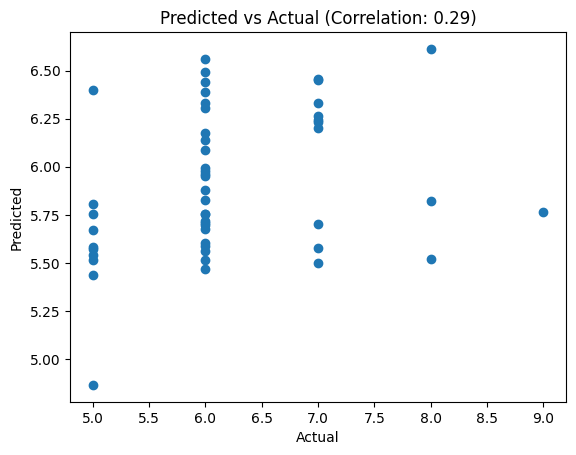

In [101]:
# 실제 값(targets)을 NumPy 배열로 변환합니다.
y_true = np.asarray(targets.numpy()).reshape(-1)
y_pred = predicted.reshape(-1)

# 상관 계수를 계산합니다.
corr_coef = np.corrcoef(y_pred, y_true)[0, 1]

# 예측 값과 실제 값을 산점도로 그립니다. 
# 

# 시각화 하는것임
plt.scatter(y_true, y_pred)
plt.ylabel("Predicted")  # y축 레이블을 설정합니다.
plt.xlabel("Actual")  # x축 레이블을 설정합니다.
plt.title(f"Predicted vs Actual (Correlation: {corr_coef:.2f})")  # 그래프 제목을 설정합니다.
plt.show()  # 그래프를 출력합니다.


## Experiment 2: Bayesian neural network (BNN)

The object of the Bayesian approach:
-  Capture the *epistemic uncertainty*, which is uncertainty about the model fitness, due to limited training data

Main idea:
-  Instead of learning specific weight (and bias) *values* in the neural network, the Bayesian approach learns weight *distributions* from which we can sample to produce an output for a given input to encode weight uncertainty

***Thus, define prior and the posterior distributions of these weights, and the training process is to learn the parameters of these distributions***

## 실험 2: 베이지안 신경망(BNN)

베이지안 접근법의 목표는 다음과 같습니다:
-  제한된 교육 데이터로 인해 모델 적합성에 대한 불확실성인 *통계학적 불확실성*을 포착합니다

주요 아이디어:
-  신경망에서 특정 가중치(및 편향) *값*을 학습하는 대신, 베이지안 접근 방식은 가중치 *분포*를 학습하여 가중치 불확실성을 인코딩하기 위해 주어진 입력에 대한 출력을 생성할 수 있습니다


위의 ANN, SNN 은 값을 통한 학습이지만 이건 분포를 통한 학습. 해당 깃 내에 있는 introduction 을 확인해보길 바람




***그러므로 이러한 가중치의 사전 및 사후 분포를 정의하고, 교육 과정은 이러한 분포의 매개 변수를 학습하는 것입니다.**


이 함수는 다변수 가우시안 분포를 반환하며, 이 분포의 학습 가능한 매개변수는 평균, 분산, 공분산입니다. 사후 분포는 베이지안 신경망의 학습 과정에서 업데이트되어 가중치에 대한 불확실성을 추정한다.


In [102]:
# 사전 가중치 분포를 평균이 0이고 표준편차가 1인 정규 분포로 정의합니다.
# 이 예제에서 사전 분포의 매개변수는 고정되어 있어 학습 가능하지 않습니다.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# 변분 사후 가중치 분포를 다변수 가우시안으로 정의합니다.
# 이 분포의 학습 가능한 매개변수는 평균, 분산, 공분산입니다.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model


- Use the `tfp.layers.DenseVariational` layer instead of the standard `keras.layers.Dense` layer in the neural network model

tfp 이거 위에서 import tensorflow_probability as tfp tensorflow_probability를 임포트 한것이고 그 라이브러리 내에 있는 Dense 를 사용하는 모델을 불러와서 사용한다는 것임.

In [103]:
# 베이지안 신경망(BNN) 모델을 생성하는 함수를 정의 입력 특성에 대한 불확실성을 고려하여 가중치를 추정
# create_bnn_model 함수는 학습 데이터셋의 크기(train_size)를 인수로 받고 있다.


def create_bnn_model(train_size):
    # 입력 레이어 생성
    inputs = create_model_inputs()

    # 입력 레이어를 연결하여 특성 벡터 생성
    features = keras.layers.concatenate(list(inputs.values()))

    # 배치 정규화 적용
    features = layers.BatchNormalization()(features)

    # create_model_inputs 함수를 호출하여 입력 레이어를 생성하고, concatenate를 사용하여 입력 레이어를 연결하여 특성 벡터를 생성한다.

    # 가중치 불확실성이 있는 은닉층 생성 (DenseVariational 레이어 사용)
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid",
        )(features)

    # hidden_units 리스트에 있는 각 원소를 사용하여 은닉층을 생성
    # 여기서는 가중치에 대한 불확실성을 고려하기 위해 DenseVariational 레이어를 사용
    # 이 레이어는 사전 분포 함수(make_prior_fn=prior)와 사후 분포 함수(make_posterior_fn=posterior)를 인수로 받고
    # Kullback-Leibler 발산(KL divergence)에 대한 가중치(kl_weight=1 / train_size)를 설정하여 모델의 복잡성을 제어한다. 
    
    # 활성화 함수로 시그모이드를 사용
    # 출력층 생성 (결정적 출력: 단일 점 추정)
    outputs = layers.Dense(units=1)(features)

    # 입력과 출력을 사용하여 모델 생성 = 베이지안 모델 = 논문의 결과물에 필요한 모델 = 이 과정을 반복
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


The epistemic uncertainty:
- Can be reduced as we increase the size of the training data
- The more data the BNN model sees, the more it is certain about its estimates for the weights (distribution parameters)

**Let's test this behaviour by training the BNN model on a small subset of the training set, and then on the full training set, to compare the output variances**

인식론적 불확실성:
- 교육 데이터의 크기를 늘리면 줄일 수 있음 = 데이터 많을수록 불확실성이 줄어진다 = 당연한 소리
- BNN 모델이 더 많은 데이터를 볼수록 가중치(분포 모수)에 대한 추정치가 더 확실해집니다

**BNN 모델을 교육 세트의 작은 하위 세트에서 교육한 다음 전체 교육 세트에서 출력 분산을 비교하여 이 동작을 테스트합니다**

### Train BNN  with a small training subset.

In [104]:
# 베이지안 신경망(BNN) 모델을 학습시키는 과정
# 총 500 num_epochs = 500 동안 모델을 학습시키며, 학습 데이터셋의 30% 크기인 작은 데이터셋(small_train_dataset)을 사용한다.

num_epochs = 500
train_sample_size = int(train_size * 0.3)
small_train_dataset = train_dataset.unbatch().take(train_sample_size).batch(batch_size)

# 전체 학습 데이터셋 크기의 30%에 해당하는 작은 데이터셋을 생성
bnn_model_small = create_bnn_model(train_sample_size)

# 작은 데이터셋의 크기를 인자로 넘겨주며 베이지안 신경망 모델을 생성
# 이미 학습된 모델이 있는 경우, 해당 모델의 가중치를 불러옵니다. 그렇지 않은 경우, 작은 데이터셋을 사용하여 모델을 학습시키고, 학습된 가중치를 저장한다.

# 모델이 더 적은 데이터로도 학습할 수 있는지 확인하는 과정이다.
if os.path.exists('pretrained_model/bnn_model_full.h5'):
    print("Model exists, load weights")
    bnn_model_small.load_weights('pretrained_model/bnn_model_small.h5')
else:
    print("Model not exists, train model")
    run_experiment(bnn_model_small, mse_loss, train_dataset, test_dataset)
    bnn_model_small.save_weights('pretrained_model/bnn_model_small.h5')

Model exists, load weights


- The trained a BNN model:
    * Produce a different output each time we call it with the same input, since each time a new set of weights are sampled from the distributions to construct the network and produce an output
    * The less certain the mode weights are, the more variability (wider range) we will see in the outputs of the same inputs




- 훈련된 BNN 모델:
    * 네트워크를 구성하고 출력을 생성하기 위해 분포에서 새로운 가중치 집합을 샘플링할 때마다 동일한 입력으로 호출할 때마다 다른 출력을 생성합니다
    * 모드 가중치가 불확실할수록 동일한 입력의 출력에서 더 많은 가변성(넓은 범위)을 확인할 수 있습니다

In [105]:
#  베이지안 신경망 모델(BNN)을 사용하여 예측을 수행하고, 예측값의 평균, 최소값, 최대값 및 범위를 계산한다. 
# 여기서 주어진 iterations는 예측값을 얻기 위해 모델을 실행할 횟수를 나타냅니다(기본값은 100회).

def compute_predictions(model, iterations=100):
    predicted = []
    for _ in range(iterations):
        predicted.append(model(examples).numpy())
    predicted = np.concatenate(predicted, axis=1)

    # iterations 만큼의 예측값을 얻기 위해 모델을 여러 번 실행한 뒤, 각 실행 결과로 얻은 예측값을 predicted 목록에 추가한다.
    # 그 다음, predicted 목록에 있는 모든 예측값을 하나의 NumPy(큰 숫자 다루는 라이브러리) 배열로 연결

    prediction_mean = np.mean(predicted, axis=1).tolist()
    prediction_min = np.min(predicted, axis=1).tolist()
    prediction_max = np.max(predicted, axis=1).tolist()
    prediction_range = (np.max(predicted, axis=1) - np.min(predicted, axis=1)).tolist()

    # 예측값의 평균, 최소값, 최대값 및 범위를 계산
    for idx in range(sample):
        print(
            f"Predictions mean: {round(prediction_mean[idx], 2)}, "
            f"min: {round(prediction_min[idx], 2)}, "
            f"max: {round(prediction_max[idx], 2)}, "
            f"range: {round(prediction_range[idx], 2)} - "
            f"Actual: {targets[idx]}"
        )

        
    return prediction_mean, prediction_min, prediction_max, prediction_range

# 각 샘플에 대해 예측값의 평균, 최소값, 최대값 및 범위를 출력하고 실제값과 비교 (compute_predictions를 이용해서)한다.
predicted_mean, predicted_min,  predicted_max, predicted_range = compute_predictions(bnn_model_small)

Predictions mean: 5.7, min: 5.03, max: 6.21, range: 1.19 - Actual: 6.0
Predictions mean: 6.23, min: 5.86, max: 6.47, range: 0.61 - Actual: 7.0
Predictions mean: 6.09, min: 5.51, max: 6.46, range: 0.95 - Actual: 6.0
Predictions mean: 5.78, min: 5.04, max: 6.26, range: 1.22 - Actual: 6.0
Predictions mean: 5.64, min: 4.93, max: 6.14, range: 1.21 - Actual: 8.0
Predictions mean: 5.46, min: 4.7, max: 6.09, range: 1.39 - Actual: 7.0
Predictions mean: 5.73, min: 5.2, max: 6.17, range: 0.97 - Actual: 5.0
Predictions mean: 5.83, min: 5.31, max: 6.17, range: 0.86 - Actual: 6.0
Predictions mean: 6.16, min: 5.85, max: 6.47, range: 0.63 - Actual: 6.0
Predictions mean: 5.78, min: 5.1, max: 6.22, range: 1.12 - Actual: 7.0
Predictions mean: 5.69, min: 5.02, max: 6.11, range: 1.09 - Actual: 5.0
Predictions mean: 6.36, min: 5.95, max: 6.56, range: 0.61 - Actual: 8.0
Predictions mean: 5.38, min: 4.81, max: 5.97, range: 1.16 - Actual: 6.0
Predictions mean: 5.97, min: 5.4, max: 6.44, range: 1.04 - Actual: 7

- Visualize the correlation between the predicted and actual wine quality scores with uncertainty

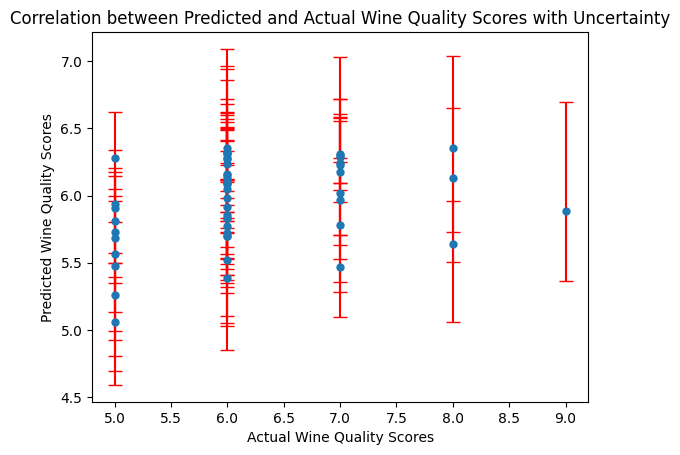

In [106]:
import matplotlib.pyplot as plt

# Calculate the errors
errors = [(predicted_mean[i] - predicted_min[i], predicted_max[i] - predicted_mean[i]) for i in range(len(predicted_mean))]
errors = np.asarray(errors).reshape(2, -1)

# Create the scatter plot with error bars
fig, ax = plt.subplots()
# ax.errorbar(y_true, predicted_mean, yerr=errors, fmt='o', ecolor='lightgray', elinewidth=3, capsize=0)
ax.errorbar(y_true, predicted_mean, yerr=errors, fmt='o',  ecolor='r', markersize=5, capsize=5)
ax.set_ylabel('Predicted Wine Quality Scores')
ax.set_xlabel('Actual Wine Quality Scores')
ax.set_title('Correlation between Predicted and Actual Wine Quality Scores with Uncertainty')
plt.show()

### Train BNN  with the whole training set.

### 전체 트케로 모델 훈련

In [107]:
# 먼저, num_epochs를 500으로 설정하고, 전체 학습 데이터셋 크기를 사용하여 BNN 모델을 생성
num_epochs = 500
bnn_model_full = create_bnn_model(train_size)

# 이전에 학습된 모델 가중치가 있는 경우 해당 가중치를 로드하고, 그렇지 않은 경우 모델을 학습시키고 가중치를 저장
if os.path.exists('pretrained_model/bnn_model_full.h5'):
    print("Model exists, load weights")
    bnn_model_full.load_weights('pretrained_model/bnn_model_full.h5')
else:
    print("Model not exists, train model")
    run_experiment(bnn_model_full, mse_loss, train_dataset, test_dataset)
    bnn_model_full.save_weights('pretrained_model/bnn_model_full.h5')

# 학습된 BNN 모델을 사용하여 예측을 수행하고 결과를 저장
predicted_mean, predicted_min,  predicted_max, predicted_range = compute_predictions(bnn_model_full)

Model exists, load weights
Predictions mean: 5.73, min: 5.16, max: 6.22, range: 1.07 - Actual: 6.0
Predictions mean: 6.18, min: 5.66, max: 6.42, range: 0.76 - Actual: 7.0
Predictions mean: 6.05, min: 5.55, max: 6.37, range: 0.82 - Actual: 6.0
Predictions mean: 5.67, min: 5.04, max: 6.25, range: 1.21 - Actual: 6.0
Predictions mean: 5.6, min: 4.96, max: 6.21, range: 1.25 - Actual: 8.0
Predictions mean: 5.46, min: 4.93, max: 6.15, range: 1.22 - Actual: 7.0
Predictions mean: 5.6, min: 5.03, max: 6.03, range: 1.0 - Actual: 5.0
Predictions mean: 5.54, min: 5.16, max: 5.92, range: 0.77 - Actual: 6.0
Predictions mean: 6.14, min: 5.64, max: 6.45, range: 0.82 - Actual: 6.0
Predictions mean: 5.75, min: 5.04, max: 6.33, range: 1.28 - Actual: 7.0
Predictions mean: 5.49, min: 5.06, max: 6.1, range: 1.04 - Actual: 5.0
Predictions mean: 6.56, min: 6.23, max: 6.67, range: 0.44 - Actual: 8.0
Predictions mean: 5.2, min: 4.74, max: 5.75, range: 1.02 - Actual: 6.0
Predictions mean: 5.89, min: 5.33, max: 6.

Notice that the model trained with the full training dataset shows smaller range
(uncertainty) in the prediction values for the same inputs, compared to the model
trained with a subset of the training dataset.



전체 교육 데이터 세트로 훈련된 모델은 더 작은 범위를 보여줍니다
모형과 비교하여 동일한 입력에 대한 예측 값에서 (반복성)
교육 데이터 세트의 하위 집합으로 교육을 받았다(처음에는 작은 규모의 트케로 트레이닝했다).

- Visualize the correlation between the predicted and actual wine quality scores with uncertainty

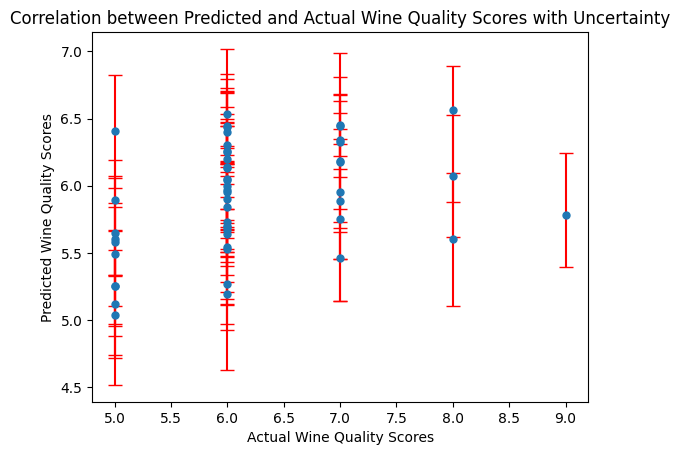

In [108]:
# 예측된 와인 품질 점수와 실제 와인 품질 점수 간의 상관 관계를 그래프로 나타내고, 예측의 불확실성을 에러로 표시함
errors = [(predicted_mean[i] - predicted_min[i], predicted_max[i] - predicted_mean[i]) for i in range(len(predicted_mean))]
errors = np.asarray(errors).reshape(2, -1)

#  예측된 평균, 최소 및 최대 값에서 에러 범위를 계산
fig, ax = plt.subplots()
# ax.errorbar(y_true, predicted_mean, yerr=errors, fmt='o', ecolor='lightgray', elinewidth=3, capsize=0)

# plt.subplots() 함수를 사용하여 새로운 그림과 축을 생성합니다.
# ax.errorbar() 함수를 사용하여 실제 와인 품질 점수와 예측된 평균 점수 사이의 관계를 나타내는 산점도를 그리고, 에러 바를 빨간색으로 표시
ax.errorbar(y_true, predicted_mean, yerr=errors, fmt='o',  ecolor='r', markersize=5, capsize=5)
ax.set_ylabel('Predicted Wine Quality Scores')
ax.set_xlabel('Actual Wine Quality Scores')
ax.set_title('Correlation between Predicted and Actual Wine Quality Scores with Uncertainty')

# x축과 y축에 레이블을 추가하고 그래프의 제목을 설정한 후 plt.show()를 호출하여 그래프를 출력한다.
# 이 그래프는 예측된 와인 품질 점수와 실제 와인 품질 점수 간의 상관 관계와 불확실성을 시각적으로 보여준다.
plt.show()

## Experiment 3: probabilistic Bayesian neural network

- So far, the output of the standard and the Bayesian NN models:
    * Deterministic: produces a point estimate as a prediction for a given example

-> To create a probabilistic NN, let's the model output a distribution

-> Captures the *aleatoric uncertainty* as well, which is due to irreducible noise in the data, or to the stochastic nature of the process generating the data

- In this example: 
    * For regression task: model the output as a `IndependentNormal` distribution, with learnable mean and variance parameters.
    * For classification (binary classes): model the output as a `IndependentBernoulli`
    * For classification (multiple classes): model the output as a `OneHotCategorical`


## 실험 3: 확률론적 베이지안 신경망

- 지금까지 표준 및 베이지안 NN 모델의 출력은 다음과 같습니다:
    * 결정론적: 주어진 예제에 대한 예측으로 점 추정치를 생성합니다

-> 확률론적 NN을 생성하기 위해, 모델이 분포를 출력합니다

-> 데이터의 환원 불가능한 노이즈 또는 데이터를 생성하는 프로세스의 확률적 특성으로 인해 발생하는 *알레알릭 불확실성*도 캡처합니다

- 이 예제에서는 다음을 수행합니다: 
    * 회귀 작업의 경우: 학습 가능한 평균 및 분산 매개 변수를 사용하여 출력을 '독립 정규' 분포로 모델링합니다.
    * 분류(이진 클래스)의 경우: 출력을 '독립 베르누이'로 모델링
    * 분류(복수 클래스)의 경우: 출력을 'OneHotCategorical'로 모델링


### 뭔가 많아보이지만 걱정하지 않아도 되는 것이 더 진보된 모델(방식)을 적용하는 것 뿐이다. 


In [109]:
#  train_size를 인수로 받아 확률론적 BNN 모델을 생성하는 함수를 정의
# 이 모델은 가중치의 불확실성을 고려하여 예측을 생성하는 데 사용

def create_probablistic_bnn_model(train_size):
    inputs = create_model_inputs()
    features = keras.layers.concatenate(list(inputs.values()))
    
    # 이후에 배치 정규화를 적용한다.
    features = layers.BatchNormalization()(features)

    
    
    # 은닉층은 tfp.layers.DenseVariational 레이어를 사용하여 구성되며, 이 레이어는 가중치의 불확실성을 고려한다.
    # 이전의 예제와 마찬가지로 시그모이드 활성화 함수를 사용한다.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid",
        )(features)



    # 출력 레이어는 정규 분포의 평균과 분산을 학습하기 위해 layers.Dense 레이어를 사용하여 확률론적 출력을 생성하고
    # tfp.layers.IndependentNormal 레이어를 사용하여 배치의 각 예제에 대한 독립적인 정규 분포를 생성
    distribution_params = layers.Dense(units=2)(features)
    outputs = tfp.layers.IndependentNormal(1)(distribution_params)

    # 입력과 출력을 사용하여 Keras 모델을 생성하고 반환
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

- Use the [negative loglikelihood](https://en.wikipedia.org/wiki/Likelihood_function) as loss function due to the output of the model is a distribution, rather than a point estimate:
    *  Compute how likely to see the true data (targets) from the
estimated distribution produced by the model.

- 모형의 출력이 점 추정치가 아닌 분포이기 때문에 손실 함수로 [역로그 우도](https://en.wikipedia.org/wiki/Likelihood_function) 를 사용합니다: (관련 공부 필요할듯)
    *  에서 실제 데이터(대상)를 볼 가능성을 계산합니다
모형에 의해 생성된 추정된 분포.

In [110]:
# 확률론적 BNN 모델을 훈련하고 저장하는 과정


# 확률론적 BNN 모델을 훈련하기 위해 손실 함수로 사용되는 negative log-likelihood를 정의
# 타겟 값과 예측된 확률 분포를 받아들이고, 확률 분포의 log 확률의 부정 값을 반환
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

# num_epochs를 1000으로 설정한 후, create_probablistic_bnn_model() 함수를 사용하여 확률론적 BNN 모델을 생성
num_epochs = 1000
prob_bnn_model = create_probablistic_bnn_model(train_size)

# 사전 훈련된 모델의 가중치가 있는지 확인
# 만약 사전 훈련된 모델의 가중치가 있다면, 이를 확률론적 BNN 모델에 로드한다.
if os.path.exists('pretrained_model/prob_bnn_model.h5'):
    print("Model exists, load weights")
    prob_bnn_model.load_weights('pretrained_model/prob_bnn_model.h5')
# 사전 훈련된 모델의 가중치가 있는지 확인합니다. 만약 사전 훈련된 모델의 가중치가 있다면, 이를 확률론적 BNN 모델에 로드
else:
    print("Model not exists, train model")
    run_experiment(prob_bnn_model, negative_loglikelihood, train_dataset, test_dataset)
    # 훈련이 완료되면, 훈련된 모델의 가중치를 저장
    prob_bnn_model.save_weights('pretrained_model/prob_bnn_model.h5')

Model exists, load weights


Now let's produce an output from the model given the test examples.
The output is now a distribution, and we can use its mean and variance
to compute the confidence intervals (CI) of the prediction.


이제 테스트 예제가 주어진 모델에서 출력을 생성해 보겠습니다.
이제 출력은 분포이며, 평균과 분산을 사용할 수 있습니다
예측의 신뢰 구간(CI)을 계산합니다.

In [111]:
#  확률론적 BNN 모델을 사용하여 예측한 결과와 실제 값 사이의 비교를 출력
prediction_distribution = prob_bnn_model(examples)

# 테스트 데이터셋의 예제를 사용하여 확률론적 BNN 모델로 예측된 분포를 계산
prediction_mean = prediction_distribution.mean().numpy().tolist()
prediction_stdv = prediction_distribution.stddev().numpy()

# The 95% CI is computed as mean ± (1.96 * stdv)
#  예측된 분포의 평균과 표준 편차를 계산
upper = (prediction_mean + (1.96 * prediction_stdv)).tolist()
lower = (prediction_mean - (1.96 * prediction_stdv)).tolist()
prediction_stdv = prediction_stdv.tolist()


# 95% 신뢰 구간 (CI)를 계산
# 평균에 ±1.96 * 표준 편차를 더하고 빼서 구간의 상한과 하한을 찾는다.
for idx in range(sample):
    # 각 예제에 대해 예측 평균, 표준 편차, 95% 신뢰 구간, 그리고 실제 값을 출력한다.
    print(
        f"Prediction mean: {round(prediction_mean[idx][0], 2)}, "
        f"stddev: {round(prediction_stdv[idx][0], 2)}, "
        f"95% CI: [{round(lower[idx][0], 2)} - {round(upper[idx][0], 2)}]"
        f" - Actual: {targets[idx]}"
    )

Prediction mean: 5.98, stddev: 0.74, 95% CI: [4.54 - 7.42] - Actual: 6.0
Prediction mean: 6.38, stddev: 0.79, 95% CI: [4.83 - 7.94] - Actual: 7.0
Prediction mean: 6.25, stddev: 0.78, 95% CI: [4.72 - 7.77] - Actual: 6.0
Prediction mean: 5.83, stddev: 0.71, 95% CI: [4.43 - 7.23] - Actual: 6.0
Prediction mean: 5.98, stddev: 0.74, 95% CI: [4.53 - 7.42] - Actual: 8.0
Prediction mean: 5.57, stddev: 0.68, 95% CI: [4.23 - 6.91] - Actual: 7.0
Prediction mean: 5.49, stddev: 0.68, 95% CI: [4.16 - 6.82] - Actual: 5.0
Prediction mean: 5.41, stddev: 0.68, 95% CI: [4.09 - 6.74] - Actual: 6.0
Prediction mean: 6.24, stddev: 0.76, 95% CI: [4.75 - 7.73] - Actual: 6.0
Prediction mean: 6.06, stddev: 0.75, 95% CI: [4.59 - 7.53] - Actual: 7.0
Prediction mean: 5.52, stddev: 0.68, 95% CI: [4.19 - 6.85] - Actual: 5.0
Prediction mean: 6.56, stddev: 0.81, 95% CI: [4.97 - 8.15] - Actual: 8.0
Prediction mean: 5.09, stddev: 0.65, 95% CI: [3.82 - 6.35] - Actual: 6.0
Prediction mean: 6.22, stddev: 0.75, 95% CI: [4.74 

- Visualize the correlation between the predicted and actual wine quality scores with uncertainty

- 예측된 와인 품질 점수와 실제 와인 품질 점수 사이의 상관 관계를 불확실성과 함께 시각화합니다


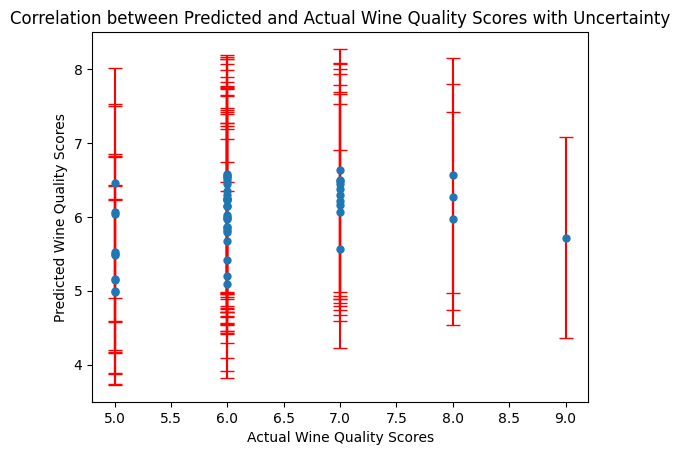

In [112]:
#  확률론적 BNN 모델의 예측과 실제 값 사이의 관계를 시각화하고, 예측의 불확실성을 나타내는 오차 막대를 추가하는 코드

prediction_mean = np.array(prediction_mean).reshape(-1)

# 예측 평균을 Numpy 배열로 변환하고, 적절한 형태로 재구성
fig, ax = plt.subplots()

# 새로운 그림과 축을 생성 에러와 함께 실제 값과 예측 평균을 기준으로 오차 막대 그래프를 생성한다.

# yerr는 95% 신뢰 구간을 나타내는 오차 막대의 크기를 결정하며, 표준 편차에 1.96을 곱하여 계산
# 오차 막대의 색상은 빨간색이며, 마커 크기는 5, 오차 막대 끝의 캡 크기는 5로 설정
ax.errorbar(y_true, prediction_mean, yerr=np.array(prediction_stdv).reshape(1, -1) * 1.96, fmt='o',  ecolor='r', markersize=5, capsize=5)

# 축 레이블과 그래프 제목을 설정
ax.set_ylabel('Predicted Wine Quality Scores')
ax.set_xlabel('Actual Wine Quality Scores')
ax.set_title('Correlation between Predicted and Actual Wine Quality Scores with Uncertainty')

# 그래프를 출력
plt.show()